### 8.4.5 GAN을 구현하는 전체 코드

In [1]:
import numpy as np
# import cupy as np # GPU를 사용하면 주석 해제
import matplotlib.pyplot as plt
from sklearn import datasets

In [2]:
# -- 각 설정값 --
img_size = 8 # 이미지의 높이와 폭
n_noise = 16 # 노이즈 수
eta = 0.001 # 학습률
n_learn = 10001 # 학습 횟수
interval = 1000 # 학습 결과 표시 간격
batch_size = 32

In [3]:
# -- 훈련 데이터 생성--
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)
x_train = x_train / 15*2-1  # -범위는 -1~1
t_train = digits_data.target

In [4]:
# -- 각 전결합 신경망층에서 상속할 입력층 --
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- 은닉층 --
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)  # He 초깃값
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)     
        self.grad_x = np.dot(delta, self.w.T)

In [5]:
# -- 생성자의 출력층 --
class GenOutLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # 자비에르 초기화 기반의 초깃값
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.tanh(u)  # tanh 함수

    def backward(self, grad_y):
        delta = grad_y * (1 - self.y**2)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)    
        self.grad_x = np.dot(delta, self.w.T) 

# -- 식별자의 출력층 --
class DiscOutLayer(BaseLayer):
    def __init__(self, n_upper, n):
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)  # 자비에르 초기화 기반의 초깃값
        self.b = np.zeros(n)

    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))  # 시그모이드 함수

    def backward(self, t):
        delta = self.y-t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)  
        self.grad_x = np.dot(delta, self.w.T) 

In [6]:
# -- 각 층의 초기화 --
gen_layers = [MiddleLayer(n_noise, 32),
              MiddleLayer(32, 64),
              GenOutLayer(64, img_size*img_size)]

disc_layers = [MiddleLayer(img_size*img_size, 64),
               MiddleLayer(64, 32),
               DiscOutLayer(32, 1)]

In [7]:
# -- 순전파 --
def forward_propagation(x, layers):
    for layer in layers:
        layer.forward(x)
        x = layer.y
    return x

# -- 역전파 --
def backpropagation(t, layers):
    grad_y = t
    for layer in reversed(layers):
        layer.backward(grad_y)
        grad_y = layer.grad_x
    return grad_y

# -- 파라미터 갱신 --
def update_params(layers):
    for layer in layers:
        layer.update(eta)

# -- 오차 계산 --
def get_error(y, t):
    eps = 1e-7
    return -np.sum(t*np.log(y+eps) + (1-t)*np.log(1-y+eps)) / len(y)  # 두 값의 교차 엔트로피 오차를 반환

# -- - 정확도 계산 -- --
def get_accuracy(y, t):
    correct = np.sum(np.where(y<0.5, 0, 1) == t)
    return correct / len(y)

In [8]:
# -- 모델 훈련 --
def train_model(x, t, prop_layers, update_layers):
    y = forward_propagation(x, prop_layers)
    backpropagation(t, prop_layers)
    update_params(update_layers)
    return (get_error(y, t), get_accuracy(y, t))

# -- 이미지를 생성하고 나타냄 --
def generate_images(i):
    # 이미지 생성
    n_rows = 16  # 행수
    n_cols = 16  # 열수
    noise = np.random.normal(0, 1, (n_rows*n_cols, n_noise))
    g_imgs = forward_propagation(noise, gen_layers)
    g_imgs = g_imgs/2 + 0.5  # 범위는 0~1

    img_size_spaced = img_size + 2
    matrix_image = np.zeros((img_size_spaced*n_rows, img_size_spaced*n_cols))  # 이미지 전체

    #  생성된 이미지를 나열해 1장의 이미지로 만듦
    for r in range(n_rows):
        for c in range(n_cols):
            g_img = g_imgs[r*n_cols + c].reshape(img_size, img_size)
            top = r*img_size_spaced
            left = c*img_size_spaced
            matrix_image[top : top+img_size, left : left+img_size] = g_img

    plt.figure(figsize=(8, 8))
    plt.imshow(matrix_image.tolist(), cmap="Greys_r")
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # 축 눈금의 레이블과 선을 삭제
    plt.show()

n_learn: 0
Error_fake: 0.521076235906188 Acc_fake: 0.9375
Error_real: 0.43510083115899745 Acc_real: 0.875


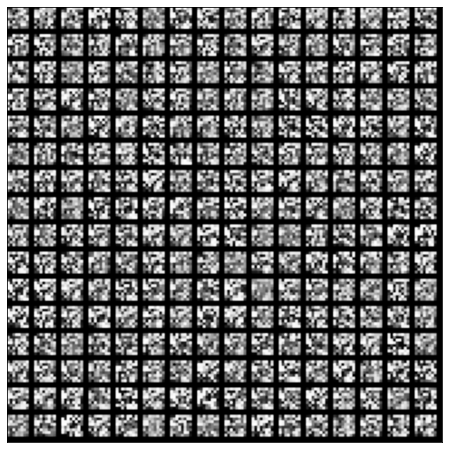

n_learn: 1000
Error_fake: 0.6436336744199739 Acc_fake: 0.6875
Error_real: 0.6328607572857615 Acc_real: 0.625


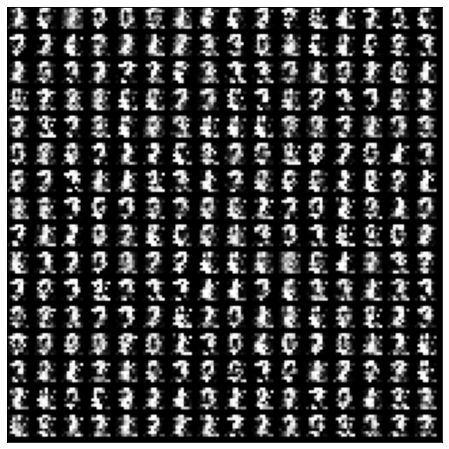

n_learn: 2000
Error_fake: 0.6301302708191542 Acc_fake: 0.75
Error_real: 0.7153052371544475 Acc_real: 0.375


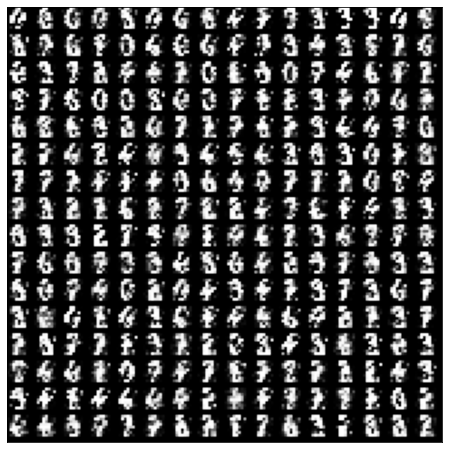

n_learn: 3000
Error_fake: 0.6343962157370666 Acc_fake: 0.75
Error_real: 0.61086373028348 Acc_real: 0.6875


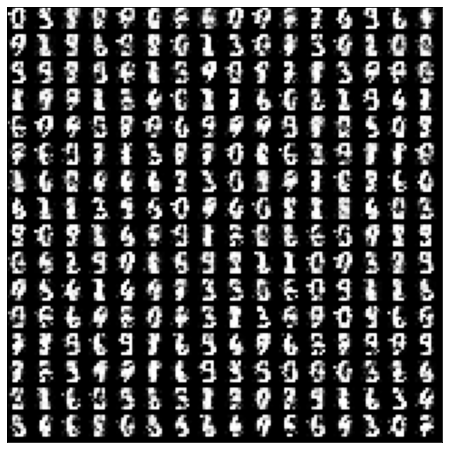

n_learn: 4000
Error_fake: 0.594928909619405 Acc_fake: 0.75
Error_real: 0.6352650187178274 Acc_real: 0.5


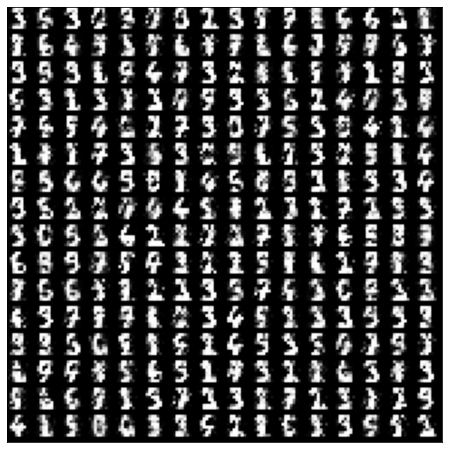

n_learn: 5000
Error_fake: 0.7378773944020153 Acc_fake: 0.5625
Error_real: 0.5086620336533075 Acc_real: 0.75


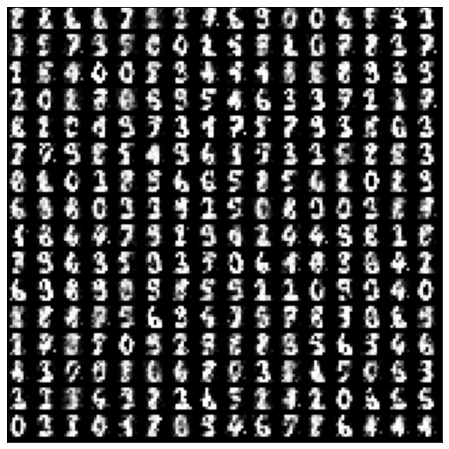

n_learn: 6000
Error_fake: 0.5710254350689759 Acc_fake: 0.75
Error_real: 0.7230575683951156 Acc_real: 0.5


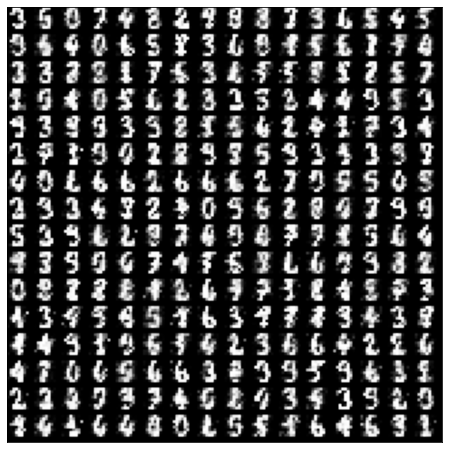

n_learn: 7000
Error_fake: 0.5883502143606415 Acc_fake: 0.75
Error_real: 0.7383234999754311 Acc_real: 0.5625


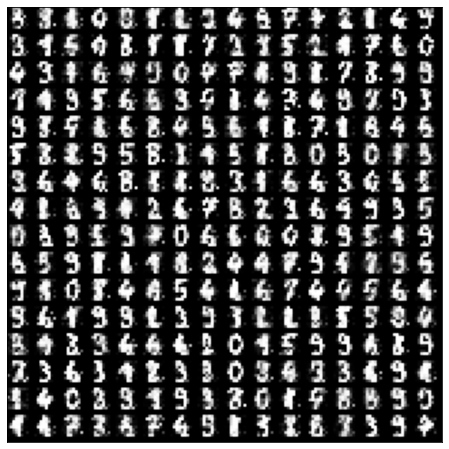

n_learn: 8000
Error_fake: 0.5447645174129937 Acc_fake: 0.75
Error_real: 0.7391391205700548 Acc_real: 0.375


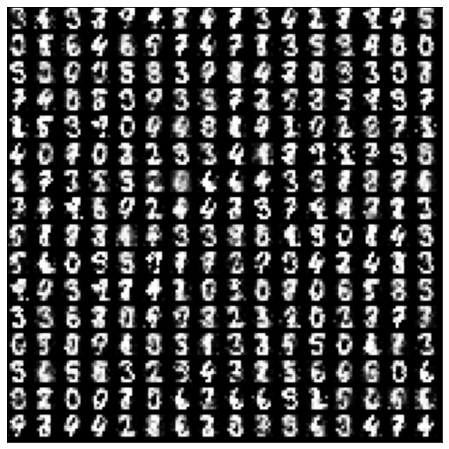

n_learn: 9000
Error_fake: 0.6653646362342899 Acc_fake: 0.5625
Error_real: 0.5555865425755719 Acc_real: 0.6875


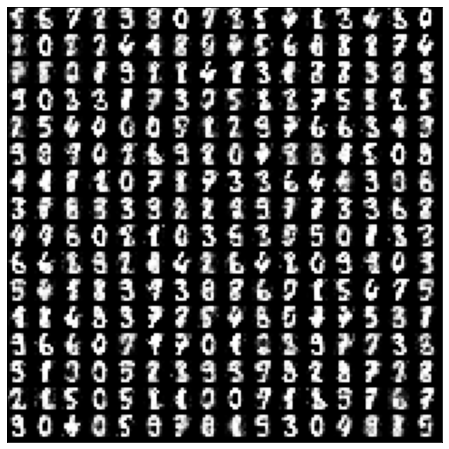

n_learn: 10000
Error_fake: 0.7693522186174584 Acc_fake: 0.5
Error_real: 0.5734373671376659 Acc_real: 0.6875


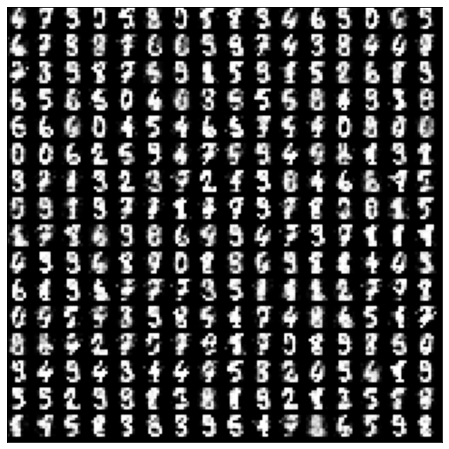

In [9]:
# -- GAN 학습 --
batch_half = batch_size // 2
error_record = np.zeros((n_learn, 2))
acc_record = np.zeros((n_learn, 2))
for i in range(n_learn):
    #  노이즈에서 이미지를 생성하여 식별자를 훈련시킴
    noise = np.random.normal(0, 1, (batch_half, n_noise))
    imgs_fake = forward_propagation(noise, gen_layers)  # 이미지 생성
    t = np.zeros((batch_half, 1))  # 정답은 0
    error, accuracy = train_model(imgs_fake, t, disc_layers, disc_layers)
    error_record[i][0] = error
    acc_record[i][0] = accuracy

    # # 실제 이미지를 사용하여 식별자를 훈련시킴
    rand_ids = np.random.randint(len(x_train), size=batch_half)
    imgs_real = x_train[rand_ids, :]
    t = np.ones((batch_half, 1))  # 정답은 1
    error, accuracy = train_model(imgs_real, t, disc_layers, disc_layers)
    error_record[i][1] = error
    acc_record[i][1] = accuracy

    # # 생성자와 식별자 모델을 결합해 생성자만 훈련시킴
    noise = np.random.normal(0, 1, (batch_size, n_noise))
    t = np.ones((batch_size, 1))  # 정답은 1
    train_model(noise, t, gen_layers+disc_layers, gen_layers)  

    # 일정한 간격으로 오차와 생성된 이미지를 나타냄
    if i % interval == 0:
        print ("n_learn:", i)
        print ("Error_fake:", error_record[i][0] , "Acc_fake:", acc_record[i][0])
        print ("Error_real:", error_record[i][1] , "Acc_real:", acc_record[i][1])
        generate_images(i)

### 8.4.6 오차와 정확도 추이

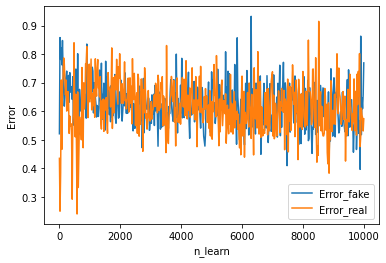

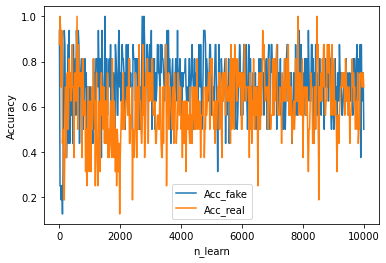

In [10]:
step = 20

# -- 오차의 추이 --
axis_x = range(1, n_learn+1, step)
axis_y = error_record[::step, :]   # step 단위로 추출
plt.plot(axis_x, axis_y[:, 0].tolist(), label="Error_fake")
plt.plot(axis_x, axis_y[:, 1].tolist(), label="Error_real")
plt.legend()
plt.xlabel("n_learn")
plt.ylabel("Error")
plt.show()

# -- 정확도 추이 --

axis_x = range(1, n_learn+1, step)
axis_y = acc_record[::step, :]
plt.plot(axis_x, axis_y[:, 0].tolist(), label="Acc_fake")
plt.plot(axis_x, axis_y[:, 1].tolist(), label="Acc_real")
plt.legend()
plt.xlabel("n_learn")
plt.ylabel("Accuracy")
plt.show()